# Worksheet 17

Name: Jian Xie
UID: U75516303

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

With only "like" and "dislike" data, I would build a recommender system using collaborative filtering based on user-user similarity.

1. Represent each user as a binary vector, with 1 for liked movies and 0 for disliked or unrated ones.
2. Calculate similarity between users using a metric like Jaccard similarity that works for binary data.
3. For each user, find the top K most similar users based on the similarity scores.
4. To generate recommendations for a user, look at the movies liked by their top K similar users that the target user hasn't watched yet. Movies liked by more of the similar users get higher recommendation scores.
5. Recommend the top N movies by recommendation score that the user hasn't seen before.

b) Describe 3 challenges of building a recommender system

1. Cold start problem - how to recommend to new users or recommend new items that have no ratings data yet. Needs fallback approaches like content-based recommendations.
2. Scalability - recommendation systems need to process huge volumes of data and serve recommendations quickly. Requires careful system design and optimization.
3. Evaluation - it's challenging to robustly evaluate recommendation quality, beyond simple accuracy measures. Need to consider metrics like diversity, novelty, coverage, and run online A/B tests.

c) Why is SVD not an option for collaborative filtering?

SVD is a matrix factorization technique commonly used in collaborative filtering, but it requires the ratings matrix to be complete (no missing values). With only likes/dislikes, the matrix will be extremely sparse with many missing entries where users haven't rated movies. SVD can't handle such sparse data.

Some matrix factorization methods like ALS can work with sparse data, but the like/dislike case is even more extreme, as the data isn't just sparse but also binary. So matrix factorization in general is not well suited here compared to neighbor-based collaborative filtering using similarity metrics designed for sparse binary data. 

d) Use the code below to train a recommender system on a dataset of amazon movies

C:\Users\XT\AppData\Local\Temp\ipykernel_82096\2476054130.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test_processed['Score'].fillna(X_test_processed['Score'].mean(), inplace=True)
D:\Anaconda3\envs\datasci\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Kaggle RMSE =  3.327160951922825


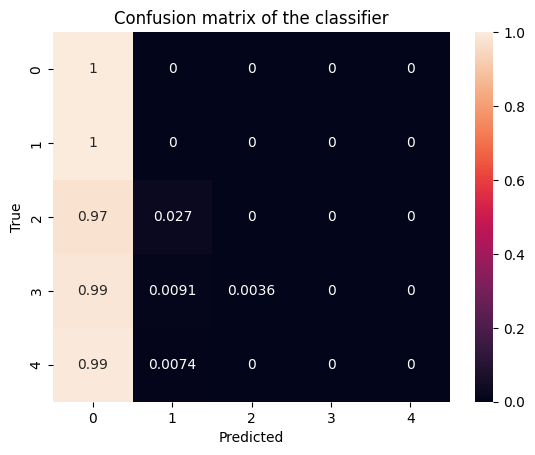

In [9]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
# param_grid = ParamGridBuilder().addGrid(
        # als.rank, [10, 50]).addGrid(
        # als.regParam, [.1]).addGrid(
        # # als.maxIter, [10]).build()
# evaluator = RegressionEvaluator(
        # metricName="rmse",
        # labelCol="Score", 
        # # predictionCol="prediction")
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
# cv_fit = cv.fit(df)
# rec_sys = cv_fit.bestModel

rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact']])).toPandas()
# X_test_processed['Score'] = rec['prediction'].values.reshape(-1, 1)
rec_df = pd.DataFrame({'UserId_fact': X_test_processed['UserId_fact'],
                       'ProductId_fact': X_test_processed['ProductId_fact'],
                       'Score': rec['prediction']})
X_test_processed = X_test_processed.merge(rec_df, on=['UserId_fact', 'ProductId_fact'], how='left')

# Fill in missing values with the mean
X_test_processed['Score'].fillna(X_test_processed['Score'].mean(), inplace=True)
# Round the predictions to integers
X_test_processed['Score'] = X_test_processed['Score'].round().astype(int)

# Now calculate RMSE
print("Kaggle RMSE = ", mean_squared_error(X_test_processed['Score'], Y_test, squared=False))

cm = confusion_matrix(Y_test, X_test_processed['Score'], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()